In [ ]:
# This script runs the model testing for linear and second degree polynomial regression on the preprocessed data.
# Access to the preprocessed data csv (preprocessed_data.csv) is required for running this script.

In [198]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np
from scipy.optimize import curve_fit

In [176]:
# load in clean data
data = pd.read_csv('preprocessed_data.csv')


In [177]:
# drop some of the rows that just categorize the states
drop_list = ['Middle Atlantic', 'East North Central', 'West North Central', 'South Atlantic', 'East South Central', 
             'West South Central', 'Mountain', 'Pacific Contiguous', 'Pacific Noncontiguous']

mask = ~data['State'].isin(drop_list)
filtered_data = data[mask]

In [ ]:
# grabbing the data we will use for training and testing our model (2001-2021)
drop_cols = ['2022', '2023', '2024', '2025']
test_data = filtered_data.drop(drop_cols, axis = 1)

In [ ]:
# checking test data
test_data.head(5)

,State,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,New England,12.095000,11.244167,11.701667,11.916667,13.445833,15.995833,16.713333,17.689167,17.500833,...,15.728333,16.233333,17.853333,19.433333,18.850833,19.435833,20.630833,21.145833,21.290833,21.546667
1,Connecticut,10.923333,10.973333,11.363333,11.640000,13.667500,16.931667,19.153333,19.617500,20.380833,...,17.385000,17.614167,19.815833,20.983333,20.117500,20.355833,21.271667,22.000000,22.824167,22.007500
2,Maine,13.180000,12.865000,12.436667,12.191667,13.361667,13.808333,16.561667,16.260833,15.618333,...,14.653333,14.356667,15.313333,15.612500,15.840833,15.966667,16.876667,17.914167,16.811667,17.041667
3,Massachusetts,12.490000,10.942500,11.614167,11.756667,13.442500,16.589167,16.235833,17.595833,16.888333,...,14.931667,15.830833,17.413333,19.821667,19.049167,20.095000,21.630833,21.942500,22.017500,22.919167
4,New Hampshire,12.460000,11.905833,12.008333,12.535833,13.557500,14.722500,14.890000,15.716667,16.405833,...,16.095833,16.365000,17.588333,18.494167,18.406667,19.242500,19.730000,20.105833,19.080833,19.915000


In [ ]:
# calculate the outliers for every year to see if any states are consistent outliers
year_list  = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', 
 '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
outlier_dict = {}
for year in year_list:
    temp_df = test_data[['State', year]]
    temp_df['z_score'] = zscore(temp_df[year])
    threshold = 2
    outliers_zscore = temp_df[abs(temp_df['z_score']) > threshold]
    outlier_dict.update({year : outliers_zscore['State'].tolist()})

In [ ]:
#print outliers 
print(outlier_dict)

{'2001': ['New York', 'Hawaii'],
 '2002': ['New York', 'Hawaii'],
 '2003': ['New York', 'Hawaii'],
 '2004': ['New York', 'Hawaii'],
 '2005': ['New York', 'Hawaii'],
 '2006': ['Hawaii'],
 '2007': ['Connecticut', 'Hawaii'],
 '2008': ['Hawaii'],
 '2009': ['Connecticut', 'Hawaii'],
 '2010': ['Connecticut', 'Hawaii'],
 '2011': ['Hawaii'],
 '2012': ['Hawaii'],
 '2013': ['Hawaii'],
 '2014': ['Hawaii'],
 '2015': ['Connecticut', 'Hawaii'],
 '2016': ['Hawaii'],
 '2017': ['Alaska', 'Hawaii'],
 '2018': ['Hawaii'],
 '2019': ['Alaska', 'Hawaii'],
 '2020': ['Connecticut', 'Alaska', 'Hawaii'],
 '2021': ['Hawaii']}

In [183]:
# cutting hawaii and alaska as outliers
drop_states = ['Hawaii', 'Alaska']

mask = ~test_data['State'].isin(drop_list)
test_data = test_data[mask]

In [185]:
# making a Contiguous US average row to use
# making a list of the average values 
av_dict = {'State': 'Cont United States'}
for year in year_list:
    av_dict.update({year : [np.nanmean(test_data[year].tolist())]})

cont_us_row = pd.DataFrame.from_dict(av_dict)

# adding the new row to the data frame
test_data = pd.concat([test_data, cont_us_row], ignore_index= True )


In [188]:
# make a training and testing sets 
year_2000 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

x_train, x_test, y_train, y_test = train_test_split(year_2000, test_data.iloc[-1].tolist()[1:], test_size = 0.2)

In [ ]:
# establish our linear regression model
model = LinearRegression()

In [ ]:
# reshape our x data since we need it to be 2D for the model
x_train1 = np.array(x_train).reshape(-1, 1)
x_test1 = np.array(x_test).reshape(-1, 1)

In [ ]:
# conduct the model fit
reg = model.fit(x_train1, y_train)

In [ ]:
# R^2 on the test data
print(reg.score(x_test1, y_test))

0.9742594822214176

In [194]:
# calculating the mean squared error
y_pred = model.predict(x_test1)
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.13453766233708078


In [ ]:
# next we will do the 2nd degree polynomial regression using numpy polyfit
coefs= np.polyfit(x_train, y_train, 2)
print(coefs)

[-0.01344365  0.61869213  7.13522098]


In [ ]:
# finding R-squared on test data
poly_func = np.poly1d(coefs)

y_pred2 = poly_func(x_test)

r_squared = r2_score(y_test, y_pred2)
print(r_squared)

0.9609542740422237


In [223]:
# finding mean squared error
mse2 = mean_squared_error(y_test, y_pred2)
print(mse2)

0.204079837857201


In [226]:
# reshaping all the x data to be 2d to run the model for the graph
x_2d = np.array(year_2000).reshape(-1, 1)

Text(0.5, 1.0, 'Linear Regression on Average Energy Cost in the Continental US')

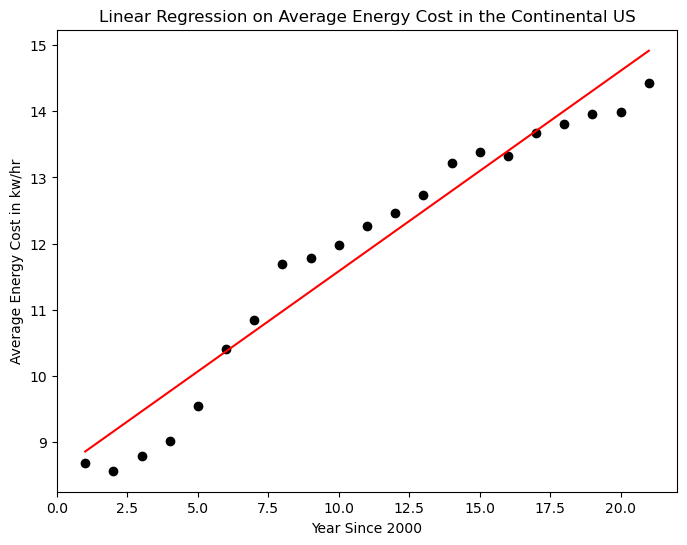

In [ ]:
# graph of the linear regression model
# making the y values for the linear regression on train and test x values 
lin_pred = model.predict(x_2d)

# plt the linear regression with the original data 
plt.figure(figsize = (8, 6))
plt.scatter(year_2000, test_data.iloc[-1].tolist()[1:], color = 'black', label = 'True Cost')
plt.plot(year_2000, lin_pred, color = 'red', label = 'Linear Regression')
plt.xlabel('Year Since 2000')
plt.ylabel('Average Energy Cost in kw/hr')
plt.title('Linear Regression on Average Energy Cost in the Continental US')

Text(0.5, 1.0, '2nd Degree Polynomial Regression on Average Energy Cost in the Continental US')

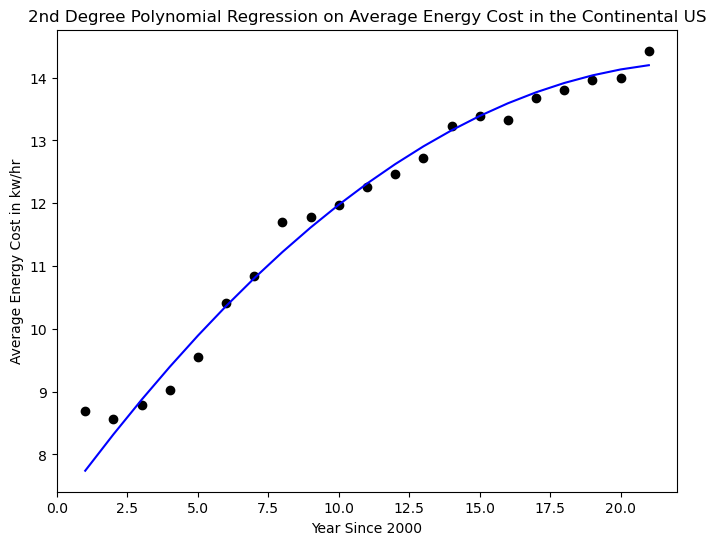

In [ ]:
# graph of the 2nd degree polynomial model

# making the y values for the polynomial fit
poly_pred = poly_func(year_2000)

# plot the figure with the 2nd degree polynomial 
plt.figure(figsize = (8, 6))
plt.scatter(year_2000, test_data.iloc[-1].tolist()[1:], color = 'black', label = 'True Cost')
plt.plot(year_2000, poly_pred, color = 'blue', label = 'Polynomial Regression')
plt.xlabel('Year Since 2000')
plt.ylabel('Average Energy Cost in kw/hr')
plt.title('2nd Degree Polynomial Regression on Average Energy Cost in the Continental US')